# Tweedie Trilogy

This is the notebook accompanying the Tweedie Trilogy blogpost series.

As modelling tasks we take frequency and severity models for the French Motor Third-Party Liability Claims datasets [freMTPL2freq](https://www.openml.org/d/41214) and [freMTPL2sev](https://www.openml.org/d/41215).
For more defails, we refer to
[Case Study: French Motor Third-Party Liability Claims](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764) with [R code](https://github.com/JSchelldorfer/ActuarialDataScience/tree/master/1%20-%20French%20Motor%20Third-Party%20Liability%20Claims) as well as the 2 scikit-learn examples [Poisson regression and non-normal loss](https://scikit-learn.org/stable/auto_examples/linear_model/plot_poisson_regression_non_normal_loss.html#sphx-glr-auto-examples-linear-model-plot-poisson-regression-non-normal-loss-py) and [Tweedie regression on insurance claims](https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html#sphx-glr-auto-examples-linear-model-plot-tweedie-regression-insurance-claims-py).

## Table of Contents <a class="anchor" id="toc"></a>
* [0 Load and Prepare Datasets](#0-load)
* [1 Aggregation invariance](#1-aggregation)
* [2 GLM offsets](#2-offsets)
* [3 Full Tweedie Distribution](#3-full-tweedie)

## 0 Load and Prepare Datasets from Openml.org <a class="anchor" id="0-load"></a>
[back to table of contents](#toc)

`freMTPL2freq` is a dataset with insurance policies per row. Every row has a policy id (`IDpol`), the time under insurance cover in years (`Exposure`), the number of claims (`ClaimNb`) and several features (`Area`, `VehPower`, `VehAge`, `DrivAge`, `BonusMalus`, `VehBrand`, `VehGas`, `Density`, `Region`).

`freMTPL2sev` is a dataset with a single claim per row, the info to which policy it belongs (`IDpol`) and the ultimate claim amount (`ClaimAmount`).

We will apply some modifications to the data itself:
* We cut the number of claims to a maximum of 4, as is done in the case study paper. Reason: Data error suspected.
* We cut the exposure to a maximum of 1, as is done in the case study paper. Reason: Data error suspected.
* We cut the ClaimAmount at 100'000 per single claim (before aggregation per policy). Reason: For the largest claims, extreme value theory might apply. 100'000 is the 0.9984 quantile, claims larger than this limit account for 25% of the overall claim amount. This is a well known phenomenon for third-party liability.
* We aggregate the total claim amounts per policy id and join them to freMTPL2freq.
* With this aggregation step, we redefine ClaimNb as the number of claims with claim amount greater zero.

[back to Table of Contents](#toc)

In [1]:
import warnings

from glum import GeneralizedLinearRegressor
import matplotlib.pyplot as plt
from model_diagnostics.calibration import compute_bias
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.datasets import fetch_openml


plt.ion()
#set_config(transform_output="pandas")

# Glum emits a few of those related to newest pandas versions.
warnings.simplefilter(action="ignore", category=FutureWarning)

# GLM settings, we will use everywhere.
glm_params = {
    "alpha": 0,
    "drop_first": True,
    "gradient_tol": 1e-8,
}

In [2]:
df_freq = fetch_openml(data_id=41214, as_frame=True, parser="auto").data
df_sev = fetch_openml(data_id=41215, as_frame=True, parser="auto").data
x_cat = ["Area",  "VehBrand", "VehGas", "Region"]  # categorical features
x_num = ["VehPower", "VehAge", "DrivAge", "BonusMalus", "Density",]  # categorical features
x_vars = x_cat + x_num

# Correct dtype
df_freq["IDpol"] = df_freq["IDpol"].astype(int)
df_freq["VehGas"] = df_freq.VehGas.astype("string").str.replace("'", "").astype("category")

# Correct for unreasonable observations (that might be data error)
df_freq["ClaimNb"] = df_freq['ClaimNb'].clip(upper=4)
df_freq["Exposure"] = df_freq['Exposure'].clip(upper=1)
df_sev["ClaimAmount"] = df_sev["ClaimAmount"].clip(upper=100_000)

# Sum ClaimAmount over identical IDpol (24950 unique IDpol).
df_sev = df_sev.groupby("IDpol", as_index=False).agg(
    ClaimAmount=("ClaimAmount", "sum"),
    ClaimNb=("ClaimAmount", "count"),
)
# Note that df_freq["ClaimNb"].sum() = 36_056, but df_sev["ClaimNb"].sum() = 26_639.
# One reason for this inconsistency might be zero claims. We want to count claims only
# with strictly positive claim amounts.
# Also note that df_freq.duplicated(subset="IDpol").sum() = 0, so no duplicate IDpol
# in df_freq.

# Join
# We need pd.merge as df.join always uses index of left df.
df = pd.merge(
    left=df_freq,
    right=df_sev,
    how="left",
    on="IDpol",
    sort=False,
    suffixes=("_FREQ", ""),
)
df["ClaimNb"].fillna(0, inplace=True)
df["ClaimAmount"].fillna(0, inplace=True)
df.drop(columns="ClaimNb_FREQ", inplace=True)
df.set_index("IDpol", inplace=True)
# Now, we have df.ClaimNb.sum() = 26_444 claims left.

To make this more interesting, we reduce the number of distrint values. We bin `Density` (1607 distinct values) and `BonusMalus` (115) into 5 values, 1 to 5.
We also clip `DrivAge` (83) at 70 years and `VehAge` (78) at 50 years and also round down to the next multiple of 5.

The point here is not to make very good GLMs with non-linear and interaction terms, but GLMs simple enough to stress the main points.

In [3]:
df["Density"] = pd.cut(df["Density"], bins=5, labels=list(range(1, 6))).astype(int)
df["BonusMalus"] = pd.cut(df["BonusMalus"], bins=5, labels=list(range(1, 6))).astype(int)
df["DrivAge"] = df["DrivAge"].clip(upper=70)
df["VehAge"] = df["VehAge"].clip(upper=50)
df["DrivAge"] = df["DrivAge"] // 5 * 5
df["VehAge"] = df["VehAge"] // 5 * 5

In [4]:
df.Density.nunique(), df.BonusMalus.nunique(), df.DrivAge.nunique(), df.VehAge.nunique()

(5, 5, 12, 11)

In [5]:
df

,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimNb
IDpol,,,,,,,,,,,,
1,0.10000,D,5,0,55,1,B12,Regular,1,R82,0.0,0.0
3,0.77000,D,5,0,55,1,B12,Regular,1,R82,0.0,0.0
5,0.75000,B,6,0,50,1,B12,Diesel,1,R22,0.0,0.0
10,0.09000,B,7,0,45,1,B12,Diesel,1,R72,0.0,0.0
11,0.84000,B,7,0,45,1,B12,Diesel,1,R72,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6114326,0.00274,E,4,0,50,1,B12,Regular,1,R93,0.0,0.0
6114327,0.00274,E,4,0,40,2,B12,Regular,2,R11,0.0,0.0
6114328,0.00274,D,6,0,45,1,B12,Diesel,1,R82,0.0,0.0


## 1 Aggregation Invariance <a class="anchor" id="1-aggregation"></a>
[back to Table of Contents](#toc)

When using scikit-learn, we would need a feature preprocessing pipeline, at least for the categorical variables. But we use glum instead, which can nativelely deal with those.

### 1.1 GLMs on unaggregated data

In [6]:
# Definte target variables.
y_freq = df["ClaimNb"] / df["Exposure"]
y_sev = (df["ClaimAmount"] / df["ClaimNb"]).fillna(1e-10)  # Value does not matter as weights are set to zero.
w_freq = df["Exposure"]
w_sev = df["ClaimNb"].fillna(0)
X = df[x_vars]

# Fit GLMs, both poisson and gamma default to log link.
glm_freq = GeneralizedLinearRegressor(
    family="poisson", **glm_params
).fit(X, y_freq, sample_weight=w_freq)
glm_sev = GeneralizedLinearRegressor(
    family="gamma", **glm_params
).fit(X, y_sev, sample_weight=w_sev)

In [7]:
print(
    f"Total predicted number of claims = "
    f"{(w_freq * glm_freq.predict(X)).sum():_.2f}"
)
compute_bias(y_obs=y_freq, y_pred=glm_freq.predict(X), weights=w_freq)

Total predicted number of claims = 26_444.00


bias_mean,bias_count,bias_weights,bias_stderr,p_value
f64,u32,f64,f64,f64
1.9163e-13,678013,358360.105463,0.00061,1.0


In [8]:
print(f"Total predicted claim amounts, given claim numbers = {(w_sev * glm_sev.predict(X)).sum():_.2f}")
compute_bias(y_obs=y_sev, y_pred=glm_sev.predict(X), weights=w_sev)

Total predicted claim amounts, given claim numbers = 49_309_687.30


bias_mean,bias_count,bias_weights,bias_stderr,p_value
f64,u32,f64,f64,f64
0.283287,678013,26444.0,6.465931,0.965054


In [9]:
print(f"Total predicted claim amounts = {(w_freq * glm_freq.predict(X) * glm_sev.predict(X)).sum():_.2f}")

Total predicted claim amounts = 49_319_656.72


In [10]:
print(f"Total observed claim amounts = {df['ClaimAmount'].sum():_.2f}")

Total observed claim amounts = 49_302_196.05


Note that the balance property is only valid for the Poisson GLM, not for the Gamma GLM, and therefore also not for their product predictions.

### 1.2 GLMs on aggregated data

In [12]:
df_agg = df.groupby(x_vars, observed=True).sum().reset_index()
print(
    f"Aggregation reduced number of rows from {df.shape[0]:_}"
    f" to {df_agg.shape[0]:_}."
)

Aggregation reduced number of rows from 678_013 to 133_413.


In [13]:
# Definte target variables.
y_agg_freq = df_agg["ClaimNb"] / df_agg["Exposure"]
y_agg_sev = (df_agg["ClaimAmount"] / df_agg["ClaimNb"]).fillna(1e-10)  # Value does not matter as weights are zero.
w_agg_freq = df_agg["Exposure"]
w_agg_sev = df_agg["ClaimNb"].fillna(0)
X_agg = df_agg[x_vars]

# Fit GLMs.
glm_agg_freq = GeneralizedLinearRegressor(
    family="poisson", **glm_params
).fit(X_agg, y_agg_freq, sample_weight=w_agg_freq)
glm_agg_sev = GeneralizedLinearRegressor(
    family="gamma", **glm_params
).fit(X_agg, y_agg_sev, sample_weight=w_agg_sev)

In [14]:
print(
    f"Total predicted number of claims = "
    f"{(w_agg_freq * glm_agg_freq.predict(X_agg)).sum():_.2f}"
)
compute_bias(y_obs=y_agg_freq, y_pred=glm_agg_freq.predict(X_agg), weights=w_agg_freq)

Total predicted number of claims = 26_444.00


bias_mean,bias_count,bias_weights,bias_stderr,p_value
f64,u32,f64,f64,f64
1.9162e-13,133413,358360.105463,0.000634,1.0


In [15]:
print(f"Total predicted claim amounts, given claim numbers = {(w_agg_sev * glm_agg_sev.predict(X_agg)).sum():_.2f}")
compute_bias(y_obs=y_agg_sev, y_pred=glm_agg_sev.predict(X_agg), weights=w_agg_sev)

Total predicted claim amounts, given claim numbers = 49_309_687.30


bias_mean,bias_count,bias_weights,bias_stderr,p_value
f64,u32,f64,f64,f64
0.283287,133413,26444.0,12.962511,0.982564


In [16]:
print(f"Total predicted claim amounts = {(w_agg_freq * glm_agg_freq.predict(X_agg) * glm_agg_sev.predict(X_agg)).sum():_.2f}")

Total predicted claim amounts = 49_319_656.72


In [17]:
print(f"Total observed claim amounts = {df_agg['ClaimAmount'].sum():_.2f}")

Total observed claim amounts = 49_302_196.05


**Remark:** All total predicted numbers are the same, mean bias and bias weights are also the same.
Even the total predicted claim amount, i.e. summing the product of frequency and severity model, returns the exact same number.
Only the p-values and bias standard errors are different.
This has to do with the estimation of weighted variances.
But the difference is small.

Finally, we show that even the GLM coefficients are the same (up to numerical precision)!

In [18]:
print(
    f"intercept freq{'':<18}= {glm_freq.intercept_}\n"
    f"intercept freq aggregated model = {glm_agg_freq.intercept_}"
)
np.max(np.abs(glm_freq.coef_ - glm_agg_freq.coef_)) < 1e-13

intercept freq                  = -3.756437676421677
intercept freq aggregated model = -3.756437676421675


True

**This aggregation invariance property holds for all GLMs** (with EDF, without penalties)**, logistic regression included, and not just for Tweedie GLMs.**

## 2 GLM Offsets <a class="anchor" id="2-offsets"></a>
[back to Table of Contents](#toc)

### 2.1 Poisson GLM
In this second part, we turn our attention to GLM offsets. We start with the Poisson frequency model where offsets and weights are equivalent.

In [32]:
# Model counts N = w * freq with offsets (but without weights)
N = w_freq * y_freq
glm_offset_freq = GeneralizedLinearRegressor(
    family="poisson", **glm_params
).fit(X, N, offset=np.log(w_freq))

In [33]:
print(
    f"intercept freq{'':<8}= {glm_freq.intercept_}\n"
    f"intercept freq offset = {glm_offset_freq.intercept_}"
)
np.max(np.abs(glm_freq.coef_ - glm_offset_freq.coef_)) < 1e-13

intercept freq        = -3.756437676421677
intercept freq offset = -3.7564376764216725


True

In [21]:
np.max(np.abs(w_freq * glm_freq.predict(X) - glm_offset_freq.predict(X, offset=np.log(w_freq))))

7.105427357601002e-15

### 2.2 Gamma GLM

For all other GLMs, except the Poisson case, this equivalence does not hold.

In [28]:
# To make sure that the filter of w_sev > 0 does not change anything.
w_gt_0 = w_sev > 0
np.max(np.abs(
    glm_sev.coef_ -
    GeneralizedLinearRegressor(
        family="gamma", **glm_params
    ).fit(
        X[w_gt_0], y_sev[w_gt_0], sample_weight=w_sev[w_gt_0]
    ).coef_
))

1.8596235662471372e-15

In [36]:
# Model severity with weights (but without offsets)
y_sev = (df["ClaimAmount"] / df["ClaimNb"])
w_sev = df["ClaimNb"].fillna(0)
X = df[x_vars]
# Filter out zero count (w_sev==0) rows
w_gt_0 = w_sev > 0
y_sev = y_sev[w_gt_0]
X_sev = X[w_gt_0]
w_sev = w_sev[w_gt_0]

glm_sev = GeneralizedLinearRegressor(
    family="gamma", **glm_params
).fit(X_sev, y_sev, sample_weight=w_sev)

In [39]:
# Note that the target is claim amount = w * sev.
claim_amount = w_sev * y_sev
glm_offset_sev = GeneralizedLinearRegressor(
    family="gamma", **glm_params
).fit(X_sev, claim_amount, offset=np.log(w_sev))

In [46]:
print(
    f"intercept sev{'':<8}= {glm_sev.intercept_}\n"
    f"intercept sev offset = {glm_offset_sev.intercept_}"
)
np.max(np.abs(glm_sev.coef_ - glm_offset_sev.coef_))

intercept sev        = 7.287909799461992
intercept sev offset = 7.236827150674156


0.2119162919285421

The deviations might seem small, but they are there and add up:

In [45]:
print(
    "Total predicted claim amounts with weights "
    f"{np.sum(w_sev * glm_sev.predict(X_sev)):_.2f}"
)
print(
    "Total predicted claim amounts offset       "
    f"{np.sum(glm_offset_sev.predict(X_sev, offset=np.log(w_sev))):_.2f}"
)

Total predicted claim amounts with weights 49_309_687.30
Total predicted claim amounts offset       48_769_342.47


Here, it becomes evident that the two models are quite different.

## 3 Full Tweedie Distribution <a class="anchor" id="3-full-tweedie"></a>
[back to Table of Contents](#toc)

Here, we show highlights on how to compute the full Tweedie distribution.

### 3.X Wright's Bessel Function

$\Phi(\rho, \beta, z) = \sum_{k=0}^{\infty} \frac{z^k}{k!\Gamma(\beta+\rho k)}, \rho > -1, \beta \in R, z \in C$

see https://dlmf.nist.gov/10.46.

In [5]:
from fractions import Fraction
import mpmath
import sympy
# from sympy import Rational


def Wright_Series_MPMATH(rho, beta, z, dps=20, method='r+s+e', **kwargs):
    """Compute Wright' generalized Bessel function as Series.
    
    This uses mpmath for arbitrary precision.
    """
    with mpmath.workdps(dps):
        res = mpmath.nsum(
            lambda k: z**k/mpmath.fac(k) * mpmath.rgamma(rho * k + beta),
            [0, mpmath.inf],
            tol=dps, method=method, **kwargs,
        )
        res = sympy.Float(res)

    return res

In [6]:
Wright_Series_MPMATH(1, Fraction(1, 2), 1, dps=20)

2.1225916201773919085

## 4. Integral Representation

Numerical Evaluation:
- Y. F. Luchko (2008), Algorithms for Evaluation of the Wright Function for the Real Arguments’ Values,<br>
  Fractional Calculus and Applied Analysis 11(1), https://eudml.org/doc/11309 or [direct link](http://sci-gems.math.bas.bg/jspui/bitstream/10525/1298/1/fcaa-vol11-num1-2008-57p-75p.pdf)

<br>
See Luchko (2008). Note that the definition of $P(\rho, \beta, x, \epsilon, \varphi)$ in Eq. (9) has a misprint.
$a=\rho$ and $b=\beta$
$$K(a, b, x, r) = \exp(-r + x \cdot r^{-a} \cos(\pi a)) \cdot r^{-b} \cdot
                  \sin(x \cdot r^{-a} \sin(\pi a) + \pi b)$$
$$P(\epsilon, a, b, x, \varphi) = \exp(\epsilon \cos(\varphi) + x \cdot \epsilon^{-a} \cos(a \varphi))
                          \cdot \cos(\epsilon \sin(\varphi) - x \cdot \epsilon^{-a} \sin(a \varphi)
                              + (1-b) \varphi)$$
Then
$$\Phi(a, b, x) = \frac{1}{\pi} \int_{\epsilon}^\inf K(a, b, x, r) \; dr
        + \frac{\epsilon^{1-b}}{\pi} \int_0^\pi P(\epsilon, a, b, x, \varphi) \; d\varphi$$

for any $\epsilon > 0$.

### 4.1 Definition of Integral Representation

In [184]:
import scipy.integrate
from scipy.integrate import quad, fixed_quad

def K(rho, beta, x, r):
    r_rho = np.power(r, -rho)
    return np.exp(-r + x * r_rho * np.cos(np.pi*rho)) \
        * np.power(r, -beta) \
        * np.sin(x * r_rho * np.sin(np.pi * rho) + np.pi * beta)

def Kmod(eps, rho, beta, x, r):
    """Kmod = K(rho, beta, x, r+eps) / exp(-r-eps)"""
    r_rho = np.power(r+eps, -rho)
    return np.exp(x * r_rho * np.cos(np.pi*rho)) \
        * np.power(r+eps, -beta) \
        * np.sin(x * r_rho * np.sin(np.pi * rho) + np.pi * beta)

def Pfull(eps, rho, beta, x, phi):
    eps_rho = np.power(1.*eps, -rho)
    return np.exp(eps*np.cos(phi) + x * eps_rho * np.cos(rho*phi)) \
        * np.cos(eps*np.sin(phi) - x * eps_rho * np.sin(rho*phi) + (1-beta)*phi)

def P(rho, beta, x, phi):
    """Beware of misprint in Luchko!!!"""
    return np.exp(np.cos(phi) + x * np.cos(rho*phi)) \
        * np.cos(np.sin(phi) - x * np.sin(rho*phi) + (1-beta)*phi)


def Wright_Integral_quad(rho, beta, z, error_out=False, eps=1e-10, epsrel=1e-10):
    if rho <= -1:
        raise ValueError("rho must be larger than -1.")    
    
    # boundary r0 for integral over K according to Luchko:
    if z * np.cos(np.pi*rho) <= 0:
        if beta >= 0:
            r0 = -np.log(eps)
        else:
            r0 = max(-beta + 1,
                     -2 * np.log(eps * np.power(-2.*beta, beta)/(-beta + 2)))
    elif beta >= 0:
        r0 = max(-2 * np.log(eps*np.power(2., beta-1)), \
                 np.power(2 * z * np.cos(rho*np.pi), 1/(1+rho)))
    else:
        r0 = max(2 * (-beta + 1), \
                 -4 * np.log(eps * np.power(-4.*beta, beta) / (2*(-beta + 2))), \
                 np.power(2 * z * np.cos(rho*np.pi), 1/(1+rho)))

    if z > 0:
        if (rho < 0 and beta <= 1) or (rho == 0 and beta < 1):
            K_int = quad(lambda r: K(rho, beta, z, r), 0, r0, epsrel=epsrel, limit=1000)
            err = 1./np.pi * K_int[1]
            res = 1./np.pi * K_int[0]
        
            if beta == 1 and rho < 0:
                res += 1.
        else:
            K_int = quad(lambda r:   K(rho, beta, z, r),   1, r0, epsrel=epsrel, limit=1000)
            P_int = quad(lambda phi: P(rho, beta, z, phi), 0, np.pi,  epsrel=epsrel, limit=1000)
            err = 1./np.pi * (K_int[1] + P_int[1])
            res = 1./np.pi * (K_int[0] + P_int[0])            
    else:
        raise NotImplementedError("z < 0 is not yet implemented.")
        
    if error_out:
        return res, err
    else:
        return res


def _cached_roots_laguerre(n):
    """Cache roots_laguerre results
    to speed up calls of the fixed_laguerre function.
    """
    if n in _cached_roots_laguerre.cache:
        return _cached_roots_laguerre.cache[n]

    _cached_roots_laguerre.cache[n] = ss.roots_laguerre(n)
    return _cached_roots_laguerre.cache[n]


_cached_roots_laguerre.cache = dict()


def fixed_laguerre(func, args=(), n=5):
    """Compute fixed order Gauss-Laguerre quadruature"""
    x, w = _cached_roots_laguerre(n)
    x = np.real(x)
    return np.sum(w*func(x, *args), axis=-1), None


def eps_select(rho, beta, z):
    """Select an appropriate eps for integration.
    a = rho, b=beta, z = x
    """
    # We use the free choice of eps to make the integral better behaved.
    # 1. Concern is oscillatory behaviour of P. Therefore, we'd like to
    #    make the change in the argument of cosine small, i.e. make arc length
    #    int_0^phi sqrt(1 + f'(phi)^2) dphi small, with
    #    f(phi) = eps * sin(phi) - x * eps^(-a) * sin(a*phi) + (1-b)*phi
    #    Proxy, make |f'(phi)| small.
    # 2. Concern is int_0 K ~ int_0 (r+eps)^(-b) .. dr
    #    This is difficult as r -> 0  for large b. It behaves better for larger
    #    values of eps.
    #
    # 1. Minimize oscillatory behaviour of P.
    #a = [2.25974, 12.3104, 0.975979, 1.57556, 2.42271, 1.94177E-03]
    #eps = a[0] * beta + a[1] * np.power(z, a[2]/(1.+rho)) * np.power(rho, a[3]) * (np.exp(-a[4]*np.sqrt(rho)) + a[5])
    A = [0.41037, 0.30833, 6.9952, 18.382, -2.8566, 2.1122]
    eps = A[0] * beta * np.exp(-0.5*rho) + np.exp(A[1] + 1/(1+rho) * np.log(z) - A[2] * np.exp(-A[3]*rho) + A[4] / (1 + np.exp(A[5]*rho)))
    if rho > 4 and z >= 100:
        eps += 1
        
    # 2. Large b
    if beta >= 8:
        # Make P small compared to K by setting eps large enough.
        # int K ~ exp(-eps) and int P ~ eps^(1-b)
        eps = max(eps, np.power(beta, -beta/(1.-beta)) + 0.1 * beta)
        
#    elif z > 1 and rho > 1:
#        # set eps such that z*eps^(-rho) = 2^(-rho)
#        eps = 2*np.power(z, 1./rho)
#    elif z > 1 and rho > 0:  # 0 < a < 1
#        # approx sin(a * phi) ~ a * phi
#        # set eps such that eps ~ a * x * eps^(-a)
#        # multiply by 2**(beta-1) to take advantage larger beta values.
#        eps = np.power(rho*z, 1./(1.+rho)) * 2**(beta-1)
#        #if z <= 5 and beta >= 5:
#        #    eps = 2*eps
#        #elif rho <= 0.1:
#        #    eps *= np.power(2, np.log10(rho))
#    else:
#        eps = 1.
    # safeguard, higher better for larger a, lower better for tiny a.
    eps = min(eps, 150)
    eps = max(eps, 3)
    return eps


def Wright_Integral(rho, beta, z, n_laguerre=50, n_legendre=50, eps=None):
    """
    Compute Wrights generalized Bessel function via integration.
    
    n_laguerre : order of quadrature rule for gauss-laguerre for integration over K.
    n_legendre : order of quadrature rule for gauss-legendre for integration over P.
    """
    if rho <= -1:
        raise ValueError("rho must be larger than -1.")    

    if z > 0:
        if (rho < 0 and beta <= 1) or (rho == 0 and beta < 1):
            # integrate from 0 to inf
            K_int = fixed_laguerre(lambda r: K(rho, beta, z, r) * np.exp(r), n=n_laguerre)[0]
            res = 1./np.pi * K_int
        
            if beta == 1 and rho < 0:
                res += 1.
        else:
            if eps is None:
                eps = eps_select(rho, beta, z)
            #print(eps)
            K_int = fixed_laguerre(lambda r: Kmod(eps, rho, beta, z, r), n=n_laguerre)
            P_int = fixed_quad(lambda phi: Pfull(eps, rho, beta, z, phi), 0, np.pi, n=n_legendre)
            res = 1./np.pi * (np.exp(-eps)*K_int[0] + np.power(eps, 1.-beta) * P_int[0])            
    else:
        raise NotImplementedError("z < 0 is not yet implemented.")
        
    return res

### 4.2 Choice of epsilon
We have integral over $K$ and integral over $P$.
We are looking for a choice of $\epsilon$ that makes both integrands numerical well behaved at the same time.

#### Integrand P
Goal: Least oscillatory behaviour of integrand => arc length of argument of $cos(...)$ of $P(\epsilon, a, b, x, \varphi)$ should be minimal.
Arc length of function $f$ is computed as $\int \sqrt{1+f'(t)^2}dt$.

We have $f(\varphi) = \epsilon \sin(\varphi) - x \epsilon^{-\rho} \sin(\rho \varphi) + (1-\beta) \varphi$ and arc length $s = \int_0^\pi \sqrt{1+f^{\prime 2}}d\varphi$

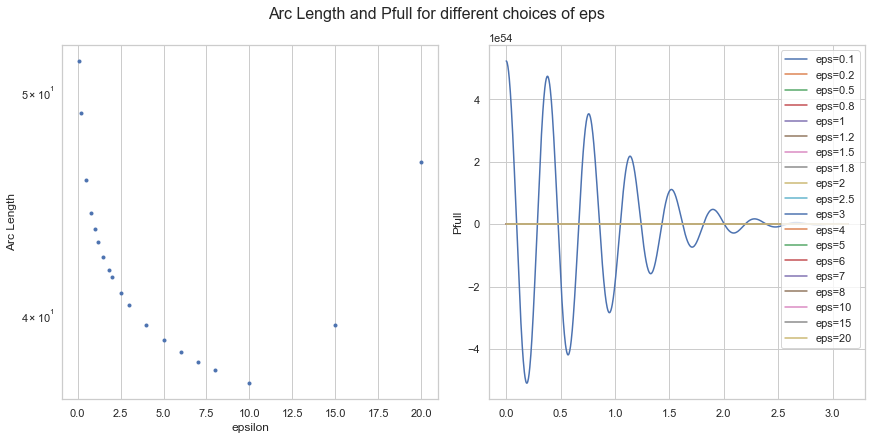

In [29]:
# Arc length of argument of cosine part of Pfull
def f(eps, rho, beta, x, phi):
    """Argument of cosine of Pfull."""
    eps_rho = np.power(1.*eps, -rho)
    return eps*np.sin(phi) - x * eps_rho * np.sin(rho*phi) + (1-beta)*phi


def fp(eps, rho, beta, x, phi):
    """Derivative w.r.t. phi"""
    eps_rho = np.power(1.*eps, -rho)
    return eps*np.cos(phi) - rho* x * eps_rho * np.cos(rho*phi) + (1-beta)

def arclength(eps, rho, beta, x, epsrel=1e-2, limit=100):
    return quad(lambda phi: np.sqrt(1 + fp(eps, rho, beta, x, phi)**2), 0, np.pi,  epsrel=epsrel, limit=100)[0]


eps = 1
rho = 1e-1
beta = 5
x = 100

fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
eps_list = [0.1, 0.2, 0.5, 0.8, 1, 1.2, 1.5, 1.8, 2, 2.5, 3, 4, 5, 6, 7, 8, 10, 15, 20]
phi = np.linspace(0, np.pi, 1_000)
res = []
for eps in eps_list:
    res.append(arclength(eps, rho, beta, x))
    # leave out np.power(eps, 1.-beta) as we are only interested in oscillation
    y2 =  Pfull(eps, rho, beta, x, phi)
    axes[1].plot(phi, y2, label=f"eps={eps}")

axes[0].plot(eps_list, res, ".")
axes[0].set_xlabel("epsilon")
axes[0].set_ylabel("Arc Length")
axes[0].set_yscale('log')
axes[1].legend(loc='upper right')
axes[1].set_ylabel("Pfull")
fig.suptitle("Arc Length and Pfull for different choices of eps", fontsize=16);